# ***Real Time Crop Health Diagnosis using Deep Learning Techniques***

## **Importing modules**

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()
import cv2 as cv

## **Exploratory Data Analysis**

In [165]:
path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

train = os.listdir(path+'/train')
key_value = dict()


for t in range(len(train)):
    key_value[train[t]] = os.listdir(path+'/train/'+train[t])
print(train)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [166]:
df = []
for i in range(len(train)):
    for j in range(len(key_value[train[i]])):
        df.append([path+'/train/'+train[i]+'/'+key_value[train[i]][j],train[i]])
ds=pd.DataFrame(df,columns=['image','label'])

In [167]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70295 entries, 0 to 70294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   70295 non-null  object
 1   label   70295 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [168]:
ds.describe()

image              label
count                                               70295              70295
unique                                              70295                 38
top     /kaggle/input/new-plant-diseases-dataset/New P...  Soybean___healthy
freq                                                    1               2022

In [169]:
display(ds)

image  \
0      /kaggle/input/new-plant-diseases-dataset/New P...   
1      /kaggle/input/new-plant-diseases-dataset/New P...   
2      /kaggle/input/new-plant-diseases-dataset/New P...   
3      /kaggle/input/new-plant-diseases-dataset/New P...   
4      /kaggle/input/new-plant-diseases-dataset/New P...   
...                                                  ...   
70290  /kaggle/input/new-plant-diseases-dataset/New P...   
70291  /kaggle/input/new-plant-diseases-dataset/New P...   
70292  /kaggle/input/new-plant-diseases-dataset/New P...   
70293  /kaggle/input/new-plant-diseases-dataset/New P...   
70294  /kaggle/input/new-plant-diseases-dataset/New P...   

                        label  
0        Tomato___Late_blight  
1        Tomato___Late_blight  
2        Tomato___Late_blight  
3        Tomato___Late_blight  
4        Tomato___Late_blight  
...                       ...  
70290  Corn_(maize)___healthy  
70291  Corn_(maize)___healthy  
70292  Corn_(maize)___healthy  
70293  Corn_(maize)___healthy  
70294  Corn_(maize)___healthy  

[70295 rows x 2 columns]

In [170]:
ds.isnull().sum()

image    0
label    0
dtype: int64

In [171]:
number_classes = {}
data_dir = pathlib.Path(r"/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train")
class_name = os.listdir(data_dir)
print(f"Total number of classes: {len(class_name)}")
for name in class_name:
  number_classes[name] = len(os.listdir(f"{data_dir}/{name}"))

number_classes

Total number of classes: 38


{'Tomato___Late_blight': 1851,
 'Tomato___healthy': 1926,
 'Grape___healthy': 1692,
 'Orange___Haunglongbing_(Citrus_greening)': 2010,
 'Soybean___healthy': 2022,
 'Squash___Powdery_mildew': 1736,
 'Potato___healthy': 1824,
 'Corn_(maize)___Northern_Leaf_Blight': 1908,
 'Tomato___Early_blight': 1920,
 'Tomato___Septoria_leaf_spot': 1745,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1642,
 'Strawberry___Leaf_scorch': 1774,
 'Peach___healthy': 1728,
 'Apple___Apple_scab': 2016,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1961,
 'Tomato___Bacterial_spot': 1702,
 'Apple___Black_rot': 1987,
 'Blueberry___healthy': 1816,
 'Cherry_(including_sour)___Powdery_mildew': 1683,
 'Peach___Bacterial_spot': 1838,
 'Apple___Cedar_apple_rust': 1760,
 'Tomato___Target_Spot': 1827,
 'Pepper,_bell___healthy': 1988,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1722,
 'Potato___Late_blight': 1939,
 'Tomato___Tomato_mosaic_virus': 1790,
 'Strawberry___healthy': 1824,
 'Apple___healthy': 2008,
 'Gra

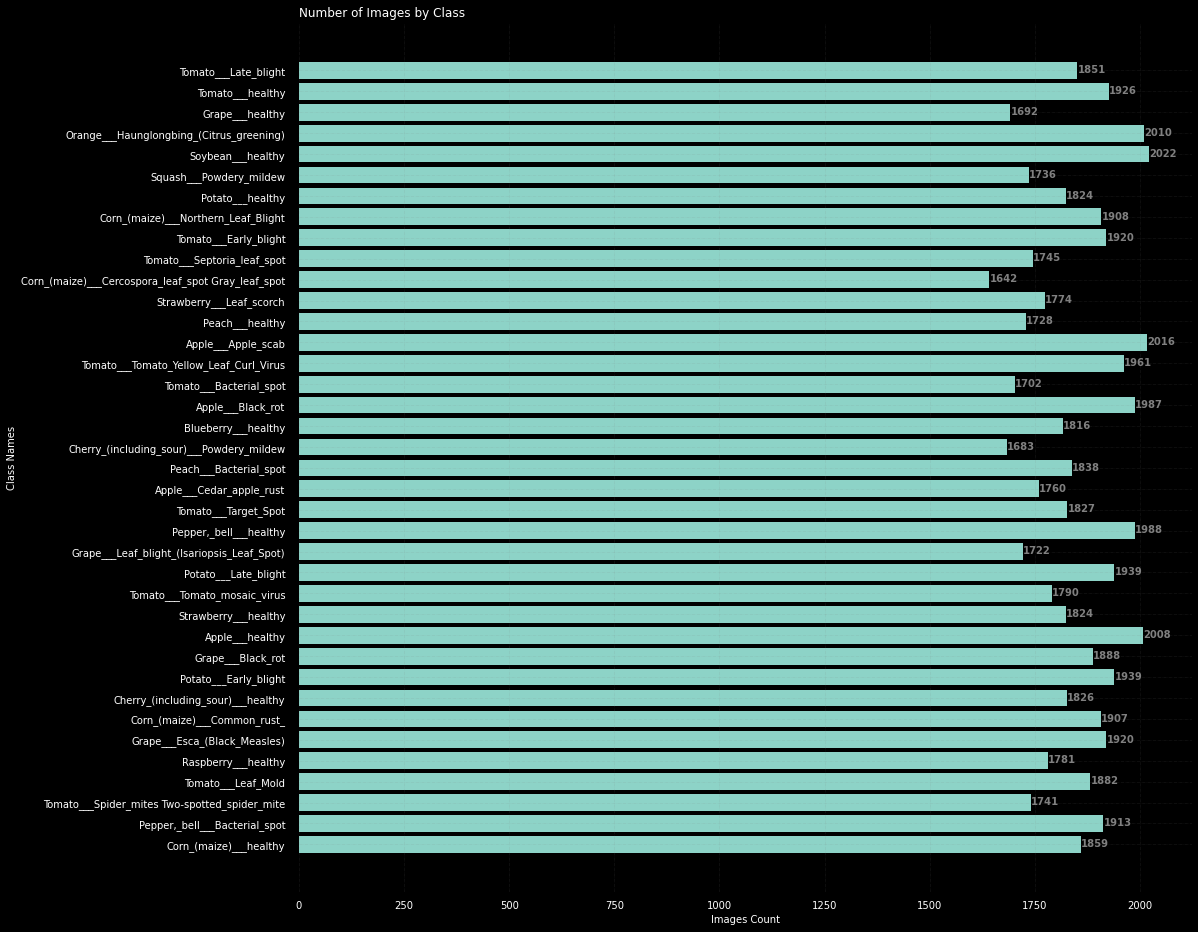

In [172]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 16))

# Horizontal Bar Plot
ax.barh(list(number_classes.keys()), list(number_classes.values()))

# Remove axis splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()


# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='grey')

# Add Plot Title
ax.set_title('Number of Images by Class',
            loc ='left', )

plt.xlabel('Images Count')
plt.ylabel('Class Names')

# Show Plot
plt.show()

In [173]:
directories = {}
for name in class_name:
  directories[name] = f"{data_dir}/{name}/"
directories

{'Tomato___Late_blight': '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Late_blight/',
 'Tomato___healthy': '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/',
 'Grape___healthy': '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___healthy/',
 'Orange___Haunglongbing_(Citrus_greening)': '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Orange___Haunglongbing_(Citrus_greening)/',
 'Soybean___healthy': '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Soybean___healthy/',
 'Squash___Powdery_mildew': '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant D

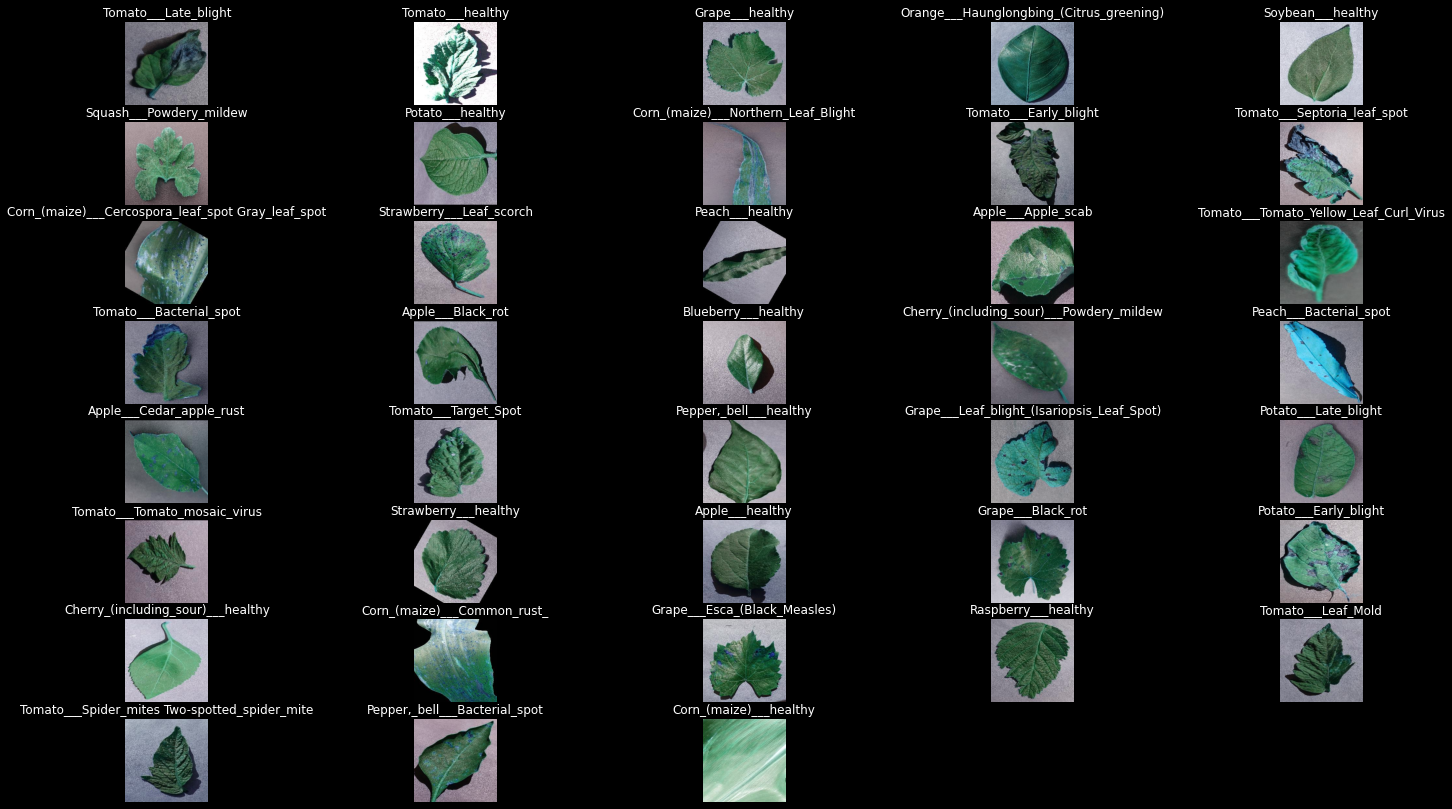

In [174]:
plt.figure(figsize=(25,18))
index = 1
for key, value in directories.items():
    img_path = value + f"{random.choice(os.listdir(value))}"
    image = cv.imread(img_path)
    ax = plt.subplot(10,5,index)
    index += 1
    plt.imshow(image.astype("int"))
    plt.title(key)
    plt.axis('off')
  

## **Image Preprocessing**

In [38]:
train_folder ='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
test_folder ='/kaggle/input/new-plant-diseases-dataset/test'
val_folder= '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [21]:
train_datagen=ImageDataGenerator(rescale=1/255
#                                 rotation_range=40,
#                                 width_shift_range=0.2,
#                                 height_shift_range=0.2,
#                                 shear_range=0.2,
#                                 zoom_range=0.2,
#                                 horizontal_flip=True,
#                                 fill_mode='nearest'
                                )
test_datagen=ImageDataGenerator(rescale=1/255)

In [22]:
training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    val_folder, 
    target_size = (224, 224),
    batch_size = 48, 
    class_mode = 'categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## **Creating and Training Model**

In [24]:
model1=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in model1.layers:
    layer.trainable=False

In [25]:
model=Sequential()
model.add(model1)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(38,activation='softmax'))

In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

### Defining callback

In [27]:
DESIRED_ACCURACY = 0.985
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > DESIRED_ACCURACY):
            print("\nLoss is low so cancelling training!")
            self.model.stop_training = True

### Compiling and Running Model

In [28]:
optimizer=tf.keras.optimizers.Adam(lr=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [29]:
callbacks = myCallback()
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[callbacks]  
)

2023-01-05 10:26:54.798239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-05 10:27:02.696102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1465/1465 [==============================] - 587s 391ms/step - loss: 0.4300 - accuracy: 0.8700 - val_loss: 0.1682 - val_accuracy: 0.9518
Epoch 2/15
1465/1465 [==============================] - 325s 222ms/step - loss: 0.1172 - accuracy: 0.9619 - val_loss: 0.1560 - val_accuracy: 0.9566
Epoch 3/15
1465/1465 [==============================] - 304s 207ms/step - loss: 0.0819 - accuracy: 0.9731 - val_loss: 0.1688 - val_accuracy: 0.9567
Epoch 4/15
1465/1465 [==============================] - 297s 203ms/step - loss: 0.0635 - accuracy: 0.9786 - val_loss: 0.1728 - val_accuracy: 0.9586
Epoch 5/15
1465/1465 [==============================] - 310s 212ms/step - loss: 0.0572 - accuracy: 0.9813 - val_loss: 0.1618 - val_accuracy: 0.9611
Epoch 6/15
1465/1465 [==============================] - 301s 206ms/step - loss: 0.0443 - accuracy: 0.9853 - val_loss: 0.1664 - val_accuracy: 0.9616

Loss is low so cancelling training!


### Plotting Model's Performance

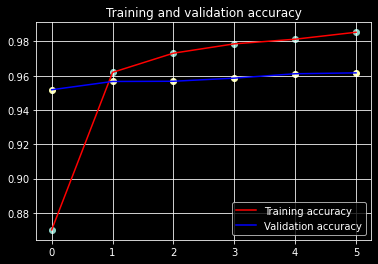

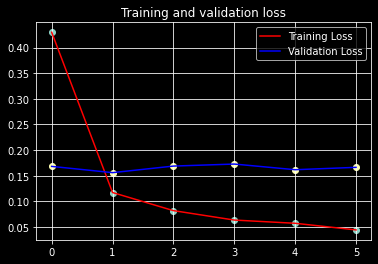

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.grid()
plt.style.use('dark_background')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs, acc)
plt.scatter(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.grid()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs, loss)
plt.scatter(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Saving model for future use

In [186]:
model.save("PlantDiseasePrediction.h5")

## **Model Testing**

In [181]:
dic=training_set.class_indices
icd={k:v for v,k in dic.items()}

def output(location,act_class):
    act_class=act_class.split(".")
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    predict_x=model.predict(img) 
    classes_x=np.argmax(predict_x,axis=1)
    print ('Predicted Class:',icd[classes_x[0]])
    print(f"Actual class: {act_class[0]}")
    print("\n")

### For predicting group of images:

Enter folder path:  /kaggle/input/new-plant-diseases-dataset/test/test


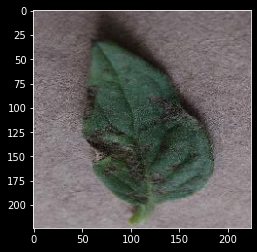

Predicted Class: Tomato___Spider_mites Two-spotted_spider_mite
Actual class: TomatoEarlyBlight6




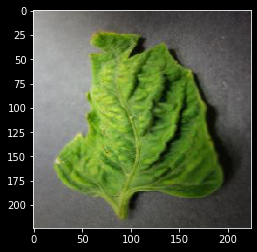

Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Actual class: TomatoYellowCurlVirus4




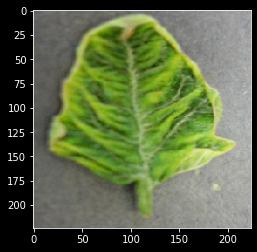

Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Actual class: TomatoYellowCurlVirus6




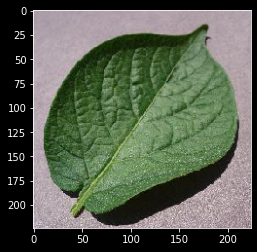

Predicted Class: Potato___healthy
Actual class: PotatoHealthy2




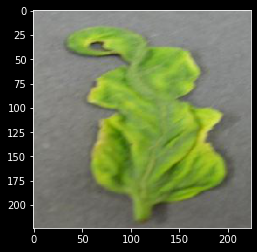

Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Actual class: TomatoYellowCurlVirus5




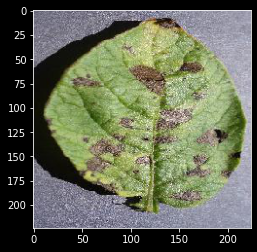

Predicted Class: Potato___Early_blight
Actual class: PotatoEarlyBlight2




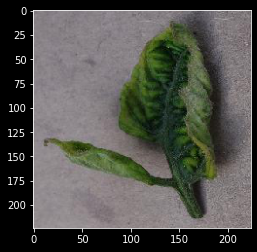

Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Actual class: TomatoYellowCurlVirus3




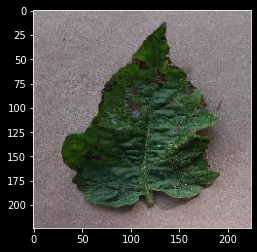

Predicted Class: Tomato___Early_blight
Actual class: TomatoEarlyBlight3




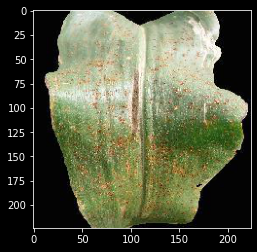

Predicted Class: Corn_(maize)___Common_rust_
Actual class: CornCommonRust2




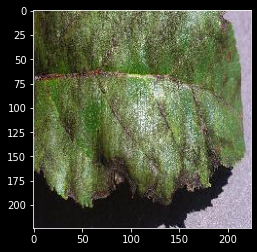

Predicted Class: Apple___Apple_scab
Actual class: AppleScab3




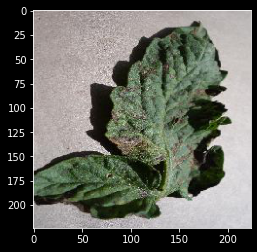

Predicted Class: Tomato___Early_blight
Actual class: TomatoEarlyBlight5




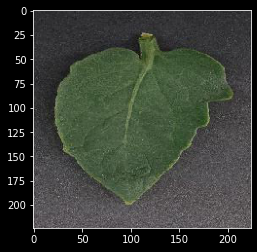

Predicted Class: Tomato___healthy
Actual class: TomatoHealthy2




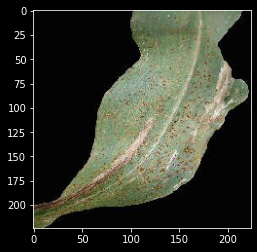

Predicted Class: Corn_(maize)___Common_rust_
Actual class: CornCommonRust1




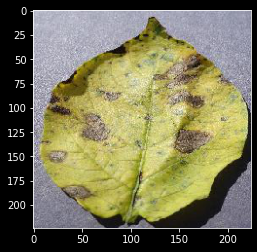

Predicted Class: Potato___Early_blight
Actual class: PotatoEarlyBlight4




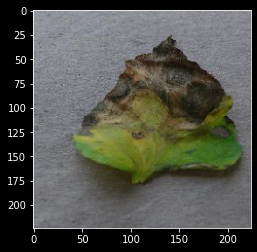

Predicted Class: Tomato___Early_blight
Actual class: TomatoEarlyBlight2




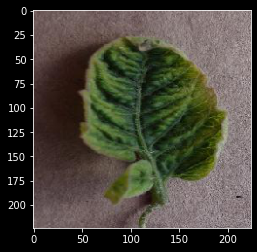

Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Actual class: TomatoYellowCurlVirus2




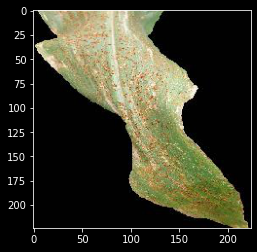

Predicted Class: Corn_(maize)___Common_rust_
Actual class: CornCommonRust3




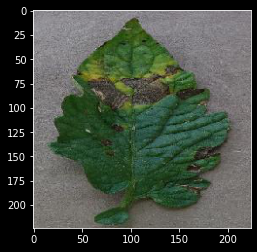

Predicted Class: Tomato___Early_blight
Actual class: TomatoEarlyBlight4




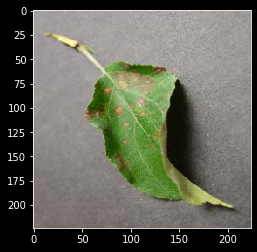

Predicted Class: Apple___Cedar_apple_rust
Actual class: AppleCedarRust3




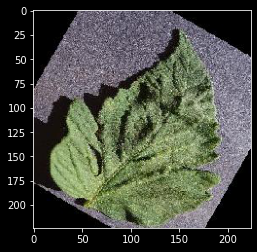

Predicted Class: Tomato___healthy
Actual class: TomatoHealthy3




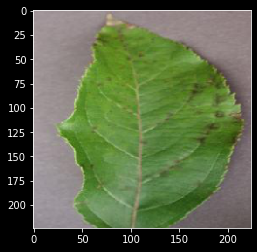

Predicted Class: Apple___Apple_scab
Actual class: AppleScab1




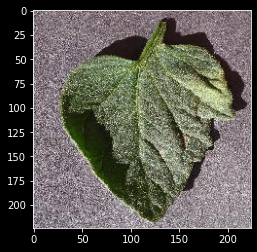

Predicted Class: Tomato___healthy
Actual class: TomatoHealthy1




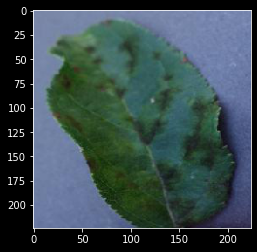

Predicted Class: Apple___Apple_scab
Actual class: AppleScab2




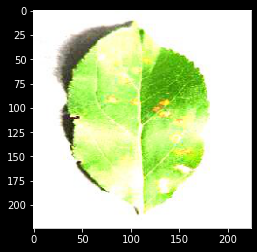

Predicted Class: Apple___Cedar_apple_rust
Actual class: AppleCedarRust1




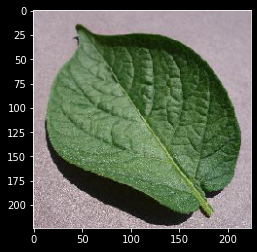

Predicted Class: Potato___healthy
Actual class: PotatoHealthy1




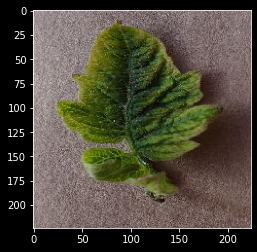

Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Actual class: TomatoYellowCurlVirus1




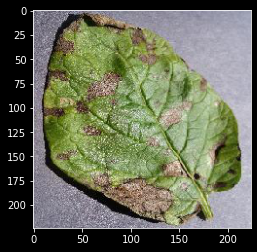

Predicted Class: Potato___Early_blight
Actual class: PotatoEarlyBlight1




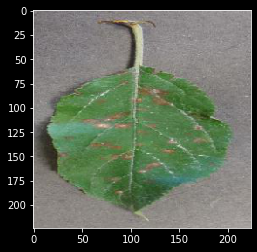

Predicted Class: Apple___Cedar_apple_rust
Actual class: AppleCedarRust2




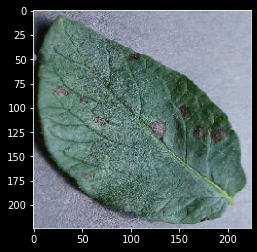

Predicted Class: Potato___Early_blight
Actual class: PotatoEarlyBlight3




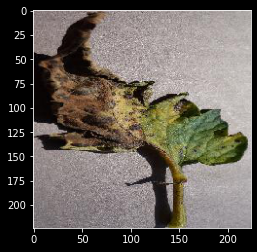

Predicted Class: Tomato___Septoria_leaf_spot
Actual class: TomatoEarlyBlight1




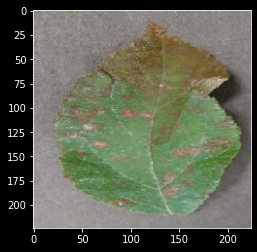

Predicted Class: Apple___Cedar_apple_rust
Actual class: AppleCedarRust4




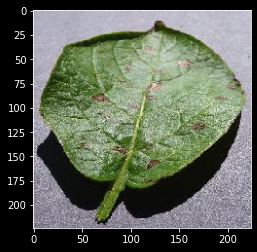

Predicted Class: Potato___Early_blight
Actual class: PotatoEarlyBlight5




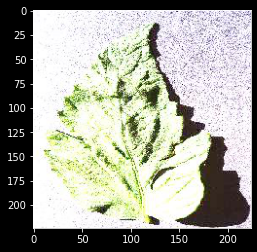

Predicted Class: Tomato___healthy
Actual class: TomatoHealthy4




In [189]:
test_fol=input("Enter folder path: ")
folder_path=os.listdir(test_fol)
for x in folder_path:
    y=x
    x=test_fol+"/"+x
    img=load_img(x,target_size=(224,224,3))
    plt.imshow(img)
    plt.show()
    output(x,y)

### For predicting single image:

Enter image path:  /kaggle/input/shubh4444455555/1200px-Rode-vlekkenziekte_(Diplocarpon_earlianum).jpg


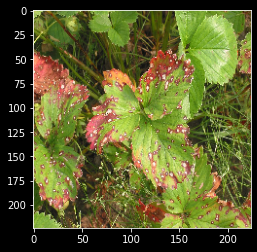

Predicted Class: Strawberry___Leaf_scorch
Actual class: 1200px-Rode-vlekkenziekte_(Diplocarpon_earlianum)




In [203]:
test_img=input("Enter image path: ")
y=test_img.split("/")
pic=load_img(test_img,target_size=(224,224,3))
plt.imshow(pic)
plt.show()
output(test_img,y[-1])


# **The End**